# Hyperparameter optimization by nested cross-validation

In this example we will see how to evaluate a model by cross-validation by coupling a hyperparameter optimization step using a nested cross-validation. The main idea here is that, for each fold, using the training data of that fold, we try to find the hyperparameters that maximize/minimize a certain objective function. Usually this objective function corresponds to a classification/regression metric (depending on the problem) obtained by cross-validation (hence the name nested cross-validation). Once we obtain a model derived from the hyperparameter optimization, we apply that model to the test data of the cross-validation fold and thus estimate its performance on that fold.

Below is a schema of the nested cross validation (__will only work in jupyterlab versions > 4.1 and jupyter > 7.1__):

```mermaid
graph TD
    A[Dataset] -->|Outer Split| B[Outer Fold 1]
    A[Dataset] -->|Outer Split| C[Outer Fold 2]
    A[Dataset] -->|Outer Split| D[Outer Fold 3]
    A[Dataset] -->|Outer Split| E[Outer Fold 4]
    A[Dataset] -->|Outer Split| F[Outer Fold 5]

    B[Outer Fold 1] --> |Inner Split - train| BA[Training data]
    B[Outer Fold 1] --> |Inner Split - test| BB[Test data]

    BA[Training data] --> |Inner CV| BAA[Cross-validation with HPO]
    BAA[Cross-validation with HPO] --> |Hyperparameter combination| BAAA[Best model]

    BAAA[Best model] --> |Predictions| BB[Test data]


    C[Outer Fold 2] --> |Inner CV| CA[Cross-validation with HPO] --> |Predictions| CAA[Test data]
    D[Outer Fold 3] --> |Inner CV| CB[Cross-validation with HPO] --> |Predictions| CBA[Test data]
    E[Outer Fold 4] --> |Inner CV| CC[Cross-validation with HPO] --> |Predictions| CCA[Test data]
    F[Outer Fold 5] --> |Inner CV| CD[Cross-validation with HPO] --> |Predictions| CDA[Test data] 

BB[Test data] --> DA[Aggregate predictions]
CAA[Test data] --> DA[Aggregate predictions]
CBA[Test data] --> DA[Aggregate predictions]
CCA[Test data] --> DA[Aggregate predictions]
CDA[Test data] --> DA[Aggregate predictions] 
```

For this example we will use the __Breast Cancer Wisconsin (Diagnostic)__ dataset.The following is a description of the dataset:

__Overview__

The Breast Cancer Wisconsin (Diagnostic) dataset is a widely used dataset for binary classification tasks in the field of machine learning. It consists of features that describe the characteristics of cell nuclei present in breast cancer biopsies. The goal is to predict whether a given sample is benign or malignant based on these characteristics.

__Dataset Characteristics__

- Number of Instances: 569
- Number of Features: 30 numeric, predictive attributes
- Class Distribution:
    - Malignant: 212 samples
    - Benign: 357 samples

__Attribute Information__

The dataset includes 10 real-valued features for each cell nucleus, which are computed for each of the 569 instances. These features are:

- Radius (mean of distances from center to points on the perimeter)
- Texture (standard deviation of gray-scale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness (perimeter^2 / area - 1.0)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry
- Fractal dimension (“coastline approximation” - 1)

For each of these features, the dataset provides the mean, standard error, and worst (largest) value. This results in a total of 30 features per instance (10 features * 3 measures = 30).

__Target Variable__

The target variable is binary and indicates the diagnosis of the breast tissue:

- 0: Malignant
- 1: Benign

_The dataset is publicly available from the UCI Machine Learning Repository and was originally curated by Dr. William H. Wolberg from the University of Wisconsin._

In [1]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

# for a simpler use, we load the different submodules of the library
#     - the gojo.core module contains all the subroutines used to evaluate the models
#     - the gojo.interfaces module provides a standardized way to interact with the different elements of gojo.core
#     - the gojo.util module implements some utilities
#     - the gojo.plotting module implements different visualization tools
from gojo import core
from gojo import interfaces
from gojo import util
from gojo import plotting


C:\Users\fgarcia\anaconda3\envs\mlv0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataset
breast_cancer = datasets.load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target
X.shape, y.shape

((569, 30), (569,))

# Initial model evaluation

First let's start by defining a simple decision tree-based model and evaluating its performance by cross-validation to get a first idea of the performance we can expect. To do this we will use the default parameters of the model and evaluate it by a five-fold cross-validation.

In [3]:
# define the model and the cross validation schema
model = interfaces.SklearnModelWrapper(model_class=DecisionTreeClassifier)
cv_obj = util.splitter.getCrossValObj(cv=5, repeats=1, stratified=True)
model

SklearnModelWrapper(
    base_model='sklearn.tree._classes.DecisionTreeClassifier',
    model_params={},
    predict_proba=False,
    supress_warnings=False
)

In [4]:
# evaluate the model using the cross-validation schema defined in the previous cell keeping the
# training set predictions to evaluate the possible overfitting
cv_report = core.evalCrossVal(
    X=X, y=y,
    model=model,
    cv=cv_obj,
    save_train_preds=True,
)
cv_report

Performing cross-validation...: 5it [00:00, 172.43it/s]


In [5]:
# calculate performance metrics
performance = cv_report.getScores(core.getDefaultMetrics('binary_classification'), supress_warnings=True)
pd.concat([
    pd.DataFrame(performance['test'].mean(), columns=['Performance (test)']).drop(index=['n_fold']).round(decimals=3),
    pd.DataFrame(performance['train'].mean(), columns=['Performance (train)']).drop(index=['n_fold']).round(decimals=3)

], axis=1)

,Performance (test),Performance (train)
accuracy,0.921,1.0
balanced_accuracy,0.920,1.0
precision,0.948,1.0
recall,0.924,1.0
sensitivity,0.924,1.0
specificity,0.915,1.0
negative_predictive_value,0.882,1.0
f1_score,0.936,1.0
auc,0.920,1.0


Now, lets use the __gojo.plotting__ module to display the confusion matrices.

In [6]:
cv_report.getTrainPredictions().head(5)

pred_labels  true_labels
n_fold indices                          
0      0                  0            0
       2                  0            0
       3                  0            0
       4                  0            0
       6                  0            0

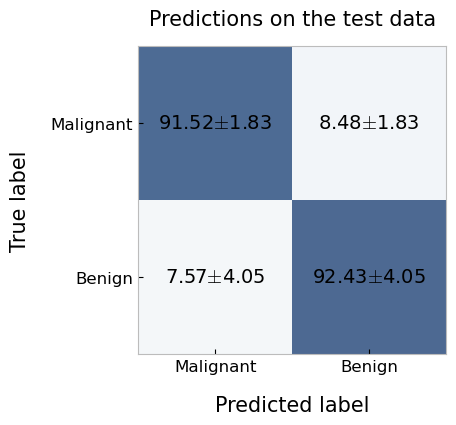

In [7]:
plotting.confusionMatrix(
    df=cv_report.getTestPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Predictions on the test data'
)

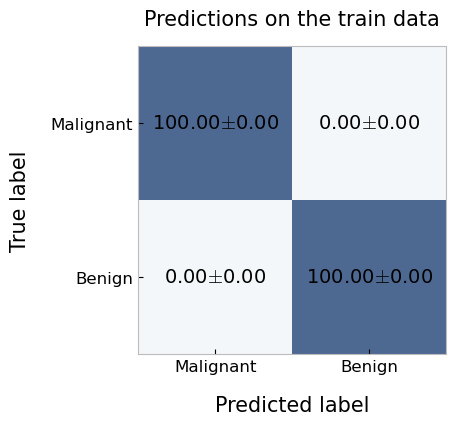

In [8]:
plotting.confusionMatrix(
    df=cv_report.getTrainPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Predictions on the train data'
)

# Hyperparameter optimization

Next we will optimize the same model as before by means of a nested cross validation as described above (outer cross-validation of 5-fold, and inner cross-validation of 5-fold). This can be easily accomplished using the __gojo.core.evalCrossValNestedHPO__ function. This function depends on the __samplers__ defined in the __[optuna](https://optuna.org/)__ library as this is the library that the function uses internally to optimize the hyperparameters.



First of all, lets define the search space (aka parameter grid) to be explored. In this case we will explore the following hyperparameters:

- Maximum tree depth
- Minimum number of samples (defined as proportion) to make a split
- Minimum number of samples (defined as proportion) that can be in a terminal node.
- Number of features considered for a split.
- Pruning parameter (_ccp\_alpha_)


Note that here some parameters are sampled considering a categorical distribution (__suggest_categorical__), others a continuous distribution (__suggest_float__), and others a continuous distribution with integers (__suggest_int__).

In [9]:
search_space = {
    'max_depth'        : ('suggest_int', (4, 15)),
    'min_samples_split': ('suggest_float', (0.01, 0.2)),
    'min_samples_leaf' : ('suggest_float', (0.01, 0.2)),
    'max_features'     : ('suggest_categorical', [('sqrt', 'log2', None)]),
    'ccp_alpha'        : ('suggest_float', (0.00, 0.5)),
}

Subsequently, we perform hyperparameter optimization using both internal and external five-fold cross-validation, and using the optuna tree-Parzen estimator (TPE) to explore the search space. The TPE model will sample the first 100 hyperparameter combinations randomly, and the remaining 300 using the distribution of values learned and refined from the first random iterations and refined from subsequent iterations. As the objective metric of hyperparameter optimization we will maximize the balanced accuracy obtained on the internal cross-validation test set.

In [10]:
# perform the HPO to optimice model-hyperparameters
hpo_cv_report = core.evalCrossValNestedHPO(
    X=X,
    y=y,
    model=model,
    search_space=search_space,
    outer_cv=util.getCrossValObj(
        cv=5, repeats=1, stratified=True, loocv=False, random_state=1997),
    inner_cv=util.getCrossValObj(
        cv=5, repeats=1, stratified=True, loocv=False, random_state=1997),
    hpo_sampler=optuna.samplers.TPESampler(n_startup_trials=100),
    hpo_n_trials=400,
    minimization=False,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    objective_metric='balanced_accuracy',
    verbose=1,
    save_train_preds=True,
    save_models=False,
    n_jobs=25
)

Performing cross-validation...: 5it [02:20, 28.06s/it]


The report obtained after calling the __evalCrossValNestedHPO__ function is exactly the same as the previous one (although as we will see below it contains more information). Let's see the confusion matrix obtained with this model and compare it with the one obtained previously.

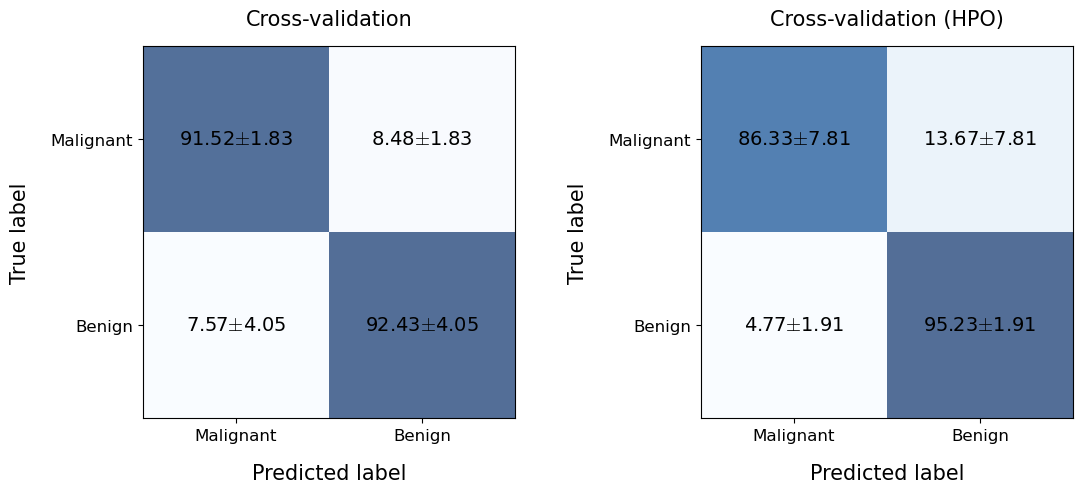

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.subplots_adjust(wspace=0.5, hspace=None)
plotting.confusionMatrix(
    df=cv_report.getTestPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Cross-validation',
    ax=axes[0],
    show=False
)

plotting.confusionMatrix(
    df=hpo_cv_report.getTestPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Cross-validation (HPO)',
    ax=axes[1],
    show=False
)

plt.show()

We see that the performance obtained by HPO is slightly worse than that obtained without optimizing the hyperparameters... however, this is because the problem addressed is quite simple in nature. However, let's see if we have a level of overfitting (recall that without HPO the model learned the training data perfectly).

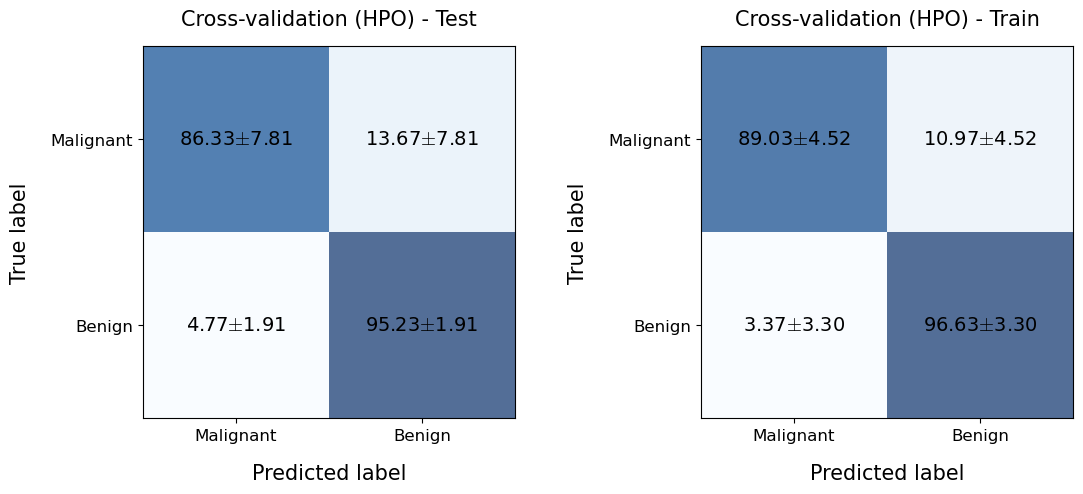

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.subplots_adjust(wspace=0.5, hspace=None)
plotting.confusionMatrix(
    df=hpo_cv_report.getTestPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Cross-validation (HPO) - Test',
    ax=axes[0],
    show=False
)

plotting.confusionMatrix(
    df=hpo_cv_report.getTrainPredictions(),
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold',
    labels=['Malignant', 'Benign'],
    title='Cross-validation (HPO) - Train',
    ax=axes[1],
    show=False
)

plt.show()

Now we see that the model does not show the extreme overfitting that we observed before which can make the model work better in a production environment.

On the other hand, the results of the HPO (the history) are stored in the __metadata__ attribute of the obtained report:

In [13]:
hpo_cv_report.metadata.keys()

dict_keys(['hpo_history', 'hpo_best_params', 'op_instance_args'])

Using the key _hpo_best_params_ we can access the best combinations of hyperparameters obtained within each cross validation. This allows us to learn about how the different hyperparameters behave.

In [14]:
pd.DataFrame(hpo_cv_report.metadata['hpo_best_params'])

,0,1,2,3,4
max_depth,12,12.000000,5,14,14
min_samples_split,0.135302,0.059464,0.168597,0.139786,0.021478
min_samples_leaf,0.128331,0.026129,0.035262,0.035723,0.016587
max_features,log2,NaN,sqrt,sqrt,sqrt
ccp_alpha,0.061524,0.011771,0.026528,0.029911,0.001725


Let's also look at the convergence of the HPO

In [15]:
hpo_cv_report.metadata['hpo_history'][0].head(5)

,number,value,datetime_start,datetime_complete,duration,params_ccp_alpha,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,state
0,0,-0.913699,2024-06-12 15:28:52.894498,2024-06-12 15:28:54.360391,0 days 00:00:01.465893,0.258801,6,log2,0.025152,0.179437,COMPLETE
1,1,-0.500000,2024-06-12 15:28:52.895498,2024-06-12 15:28:54.454688,0 days 00:00:01.559190,0.490937,8,None,0.084618,0.185654,COMPLETE
2,2,-0.912698,2024-06-12 15:28:52.897541,2024-06-12 15:28:54.302652,0 days 00:00:01.405111,0.198169,13,log2,0.114808,0.015214,COMPLETE
3,3,-0.897909,2024-06-12 15:28:52.898561,2024-06-12 15:28:54.429326,0 days 00:00:01.530765,0.024611,13,sqrt,0.084600,0.101999,COMPLETE
4,4,-0.881339,2024-06-12 15:28:52.899591,2024-06-12 15:28:54.472548,0 days 00:00:01.572957,0.196477,5,log2,0.107105,0.024681,COMPLETE


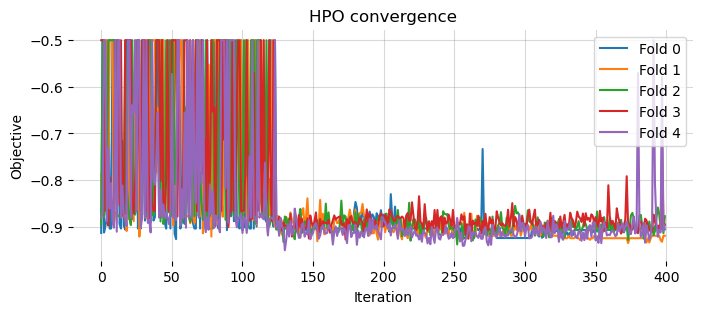

In [16]:
# plot the HPO convergence for each plot
fig, ax = plt.subplots(figsize=(8, 3))
for n_fold in hpo_cv_report.metadata['hpo_history'].keys():
    ax.plot(
        hpo_cv_report.metadata['hpo_history'][n_fold]['value'].values,
        label='Fold %d' % n_fold
    )
for pos in ['right', 'left', 'bottom', 'top']:
    ax.spines[pos].set_visible(False)
ax.grid(alpha=0.3, color='grey')
ax.legend(loc='upper right')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective')
ax.set_title('HPO convergence')
plt.show()

Alternatively, we can use some auxiliary functions of the library to represent the above graph.

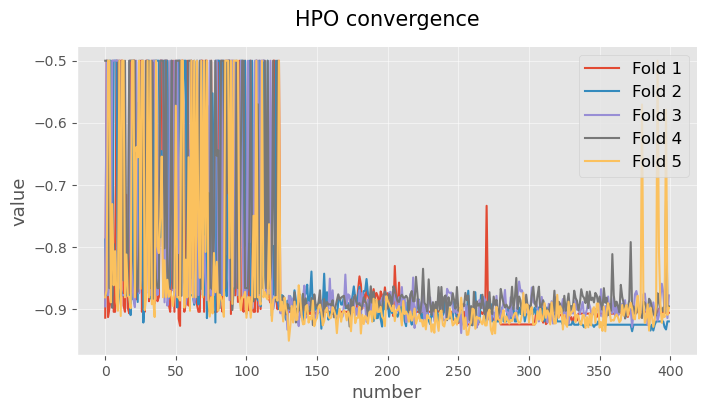

In [17]:
plotting.linePlot(
    *list(hpo_cv_report.metadata['hpo_history'].values()),
    x='number',
    y='value',
    labels=['Fold %d' % (i+1) for i in range(5)],
    figsize=(8, 4),
    title='HPO convergence',
)